### Imports

In [231]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

## Data Merging

### Load datasets

In [232]:
data_files = os.path.join(os.getcwd(), "data") #Alter accordingly if needed
accounts_df = pd.read_csv(os.path.join(data_files, "accounts.csv"))
products_df = pd.read_csv(os.path.join(data_files, "products.csv"))
sales_pipeline_df = pd.read_csv(os.path.join(data_files, "sales_pipeline.csv"))
sales_teams_df = pd.read_csv(os.path.join(data_files, "sales_teams.csv"))

### Remove duplicates



In [233]:
accounts_df.drop_duplicates(inplace=True)
products_df.drop_duplicates(inplace=True)
sales_pipeline_df.drop_duplicates(inplace=True)
sales_teams_df.drop_duplicates(inplace=True)

Fixing this issue: Sales pipeline product column is "GTXPro" without a space, while product's product has "GTX Pro" with space.

In [234]:
sales_pipeline_df['product'] = sales_pipeline_df['product'].replace("GTXPro", "GTX Pro")

In [235]:
#Verifying that worked as intended
print(sales_pipeline_df['product'].unique())

['GTX Plus Basic' 'GTX Pro' 'MG Special' 'GTX Basic' 'MG Advanced'
 'GTX Plus Pro' 'GTK 500']


### Merge datasets

In [236]:
merged_df = (
  sales_pipeline_df
  .merge(sales_teams_df, on="sales_agent", how="left")
  .merge(products_df, on="product", how="left")
  .merge(accounts_df, on="account", how="left")
)
print(merged_df.shape)
merged_df.head(10)

(8800, 18)


,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,manager,regional_office,series,sales_price,sector,year_established,revenue,employees,office_location,subsidiary_of
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01,1054.0,Dustin Brinkmann,Central,GTX,1096,retail,2001.0,718.62,2448.0,United States,NaN
1,Z063OYW0,Darcel Schlecht,GTX Pro,Isdom,Won,2016-10-25,2017-03-11,4514.0,Melvin Marxen,Central,GTX,4821,medical,2002.0,3178.24,4540.0,United States,NaN
2,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07,50.0,Melvin Marxen,Central,MG,55,retail,2001.0,718.62,2448.0,United States,NaN
3,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09,588.0,Dustin Brinkmann,Central,GTX,550,software,1998.0,2714.90,2641.0,United States,Acme Corporation
4,PE84CX4O,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02,517.0,Summer Sewald,West,GTX,550,services,1982.0,792.46,1299.0,United States,NaN
5,ZNBS69V1,Anna Snelling,MG Special,Ron-tech,Won,2016-10-29,2017-03-01,49.0,Dustin Brinkmann,Central,MG,55,medical,1992.0,3922.42,6837.0,United States,NaN
6,9ME3374G,Vicki Laflamme,MG Special,J-Texon,Won,2016-10-30,2017-03-02,57.0,Celia Rouche,West,MG,55,retail,1989.0,1388.67,3583.0,United States,NaN
7,7GN8Q4LL,Markita Hansen,GTX Basic,Cheers,Won,2016-11-01,2017-03-07,601.0,Celia Rouche,West,GTX,550,entertainment,1993.0,4269.90,6472.0,United States,Massive Dynamic
8,OLK9LKZB,Niesha Huffines,GTX Plus Basic,Zumgoity,Won,2016-11-01,2017-03-03,1026.0,Melvin Marxen,Central,GTX,1096,medical,1984.0,441.08,1210.0,United States,NaN
9,HAXMC4IX,James Ascencio,MG Advanced,NaN,Engaging,2016-11-03,NaN,NaN,Summer Sewald,West,MG,3393,NaN,NaN,NaN,NaN,NaN,NaN


In [237]:
merged_df.to_csv(os.path.join(os.getcwd(), "data", "processed", "original_merged_data.csv"), index=False)

## Handling data before EDA

### Convert date columns to proper datetime format

In [238]:
merged_df["engage_date"]=pd.to_datetime(merged_df["engage_date"], errors="coerce")
merged_df["close_date"]=pd.to_datetime(merged_df["close_date"], errors="coerce")

### Handle missing values with mode/median imputation

In [239]:
categorical_columns = merged_df.select_dtypes(include="object").columns
numerical_columns = merged_df.select_dtypes(include="float64").columns
#Handling missing values in categorical variables with mode imputation
for col in categorical_columns:
  merged_df[col]=merged_df[col].fillna(merged_df[col].mode()[0])

#Handling missing values in numerical variables with median imputation
for col in numerical_columns:
  if col not in["close_value", "close_date", "engage_date"] : # close_value should not be replaced with fake values, since a null value means the deal hasn't been closed yet.
    merged_df[col] = merged_df[col].fillna(merged_df[col].median())

In [240]:
merged_df.isnull().sum()


,0
opportunity_id,0
sales_agent,0
product,0
account,0
deal_stage,0
engage_date,500
close_date,2089
close_value,2089
manager,0
regional_office,0


## EDA on Original Dataset

In [241]:
# Summary statistics for numerical features
display(merged_df.describe().T)

# Summary statistics for categorical features however, only if any exist
cat_cols = merged_df.select_dtypes(include='object').columns
if len(cat_cols) > 0:
    display(merged_df[cat_cols].describe().T)
else:
    print("No categorical columns to summarize.")

#evaluate features most correlated with close_value (deals completed)
if "close_value" in merged_df.columns:
    corr = merged_df.corr(numeric_only=True)["close_value"].sort_values(ascending=False)
    display(corr)

,count,mean,min,25%,50%,75%,max,std
engage_date,8300,2017-06-14 08:35:06.216867584,2016-10-20 00:00:00,2017-04-04 00:00:00,2017-06-24 00:00:00,2017-08-27 00:00:00,2017-12-27 00:00:00,NaN
close_date,6711,2017-08-01 03:32:25.641484032,2017-03-01 00:00:00,2017-05-18 00:00:00,2017-08-02 00:00:00,2017-10-18 00:00:00,2017-12-31 00:00:00,NaN
close_value,6711.0,1490.915512,0.0,0.0,472.0,3225.0,30288.0,2320.670773
sales_price,8800.0,2379.109659,55.0,550.0,1096.0,4821.0,26768.0,2629.243384
year_established,8800.0,1995.405341,1979.0,1990.0,1995.0,2000.0,2017.0,8.412247
revenue,8800.0,2342.938873,4.54,718.62,1698.2,2819.5,11698.03,2393.473911
employees,8800.0,5343.471477,9.0,1588.0,3492.0,6472.0,34288.0,6293.18949


,count,unique,top,freq
opportunity_id,8800,8800,KAZ72JJ0,1
sales_agent,8800,30,Darcel Schlecht,747
product,8800,7,GTX Basic,1866
account,8800,85,Hottechi,1625
deal_stage,8800,4,Won,4238
manager,8800,6,Melvin Marxen,1929
regional_office,8800,3,Central,3512
series,8800,3,GTX,5697
sector,8800,10,retail,2822
office_location,8800,15,United States,7545


,close_value
close_value,1.000000
sales_price,0.679396
employees,0.035061
revenue,0.028136
year_established,-0.025376


Create new column for frequency graph

In [242]:
merged_df["has_close_date"] = merged_df["close_date"].notna().astype(int)
#Flagging deals without a close date
#Informative for Opportunity Win Prediction model, so that the model knows if the deal isn't closed yet

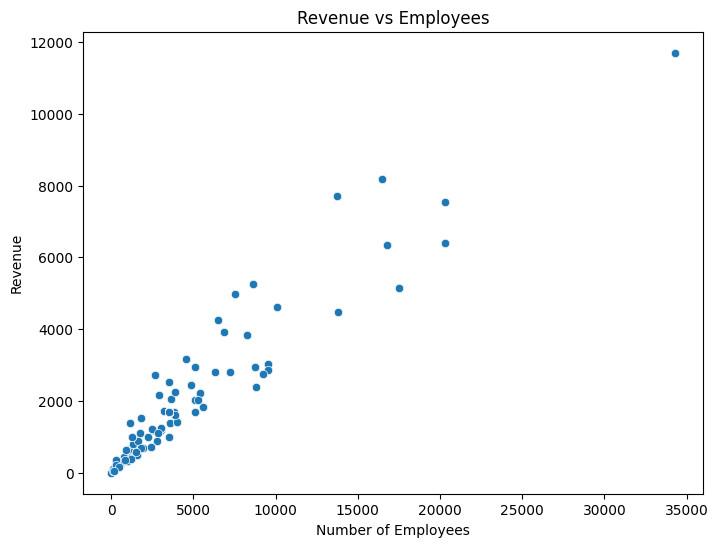

In [243]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=merged_df, x="employees", y="revenue")
plt.title("Revenue vs Employees")
plt.xlabel("Number of Employees")
plt.ylabel("Revenue")
plt.show()
#Linear relationship between the number of employees and the revenue!

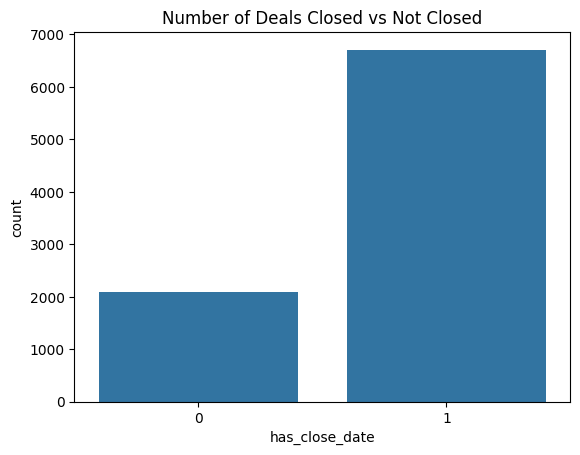

In [244]:
sns.countplot(x='has_close_date', data=merged_df)
plt.title("Number of Deals Closed vs Not Closed")
plt.show()

Summary of number of current missing values

In [245]:
missing_summary = merged_df.isnull().sum()
print(missing_summary[missing_summary > 0])

engage_date     500
close_date     2089
close_value    2089
dtype: int64


## Continuation of preprocessing

Standardize categorical values

In [246]:
for col in categorical_columns:
    merged_df[col] = merged_df[col].astype(str).str.strip().str.upper()

Handling outliers

In [247]:
for col in numerical_columns:
  if col != "close_value": #close_value should not be replaced with fake values, since a null value means the deal hasn't been closed yet.
    Q1 = merged_df[col].quantile(0.25)
    Q3 = merged_df[col].quantile(0.75)
    IQR = Q3-Q1

    lower_side = Q1 -1.5 *IQR
    upper_side = Q3 +1.5 * IQR

    merged_df[col]=merged_df[col].clip(lower=lower_side, upper=upper_side)

In [248]:
cols_to_log = ["close_value", "revenue", "employees"]

for col in cols_to_log:
    merged_df[col + "_log"] = np.log1p(merged_df[col])

merged_df[["close_value", "close_value_log",
           "revenue", "revenue_log",
           "employees", "employees_log"]].head()

,close_value,close_value_log,revenue,revenue_log,employees,employees_log
0,1054.0,6.961296,718.62,6.578723,2448.0,7.803435
1,4514.0,8.415160,3178.24,8.064397,4540.0,8.420903
2,50.0,3.931826,718.62,6.578723,2448.0,7.803435
3,588.0,6.378426,2714.90,7.906879,2641.0,7.879291
4,517.0,6.249975,792.46,6.676403,1299.0,7.170120


Encode categorical variables

In [249]:
label_enc = LabelEncoder()
cols_to_label_encode = ["sales_agent", "account", "office_location"] # only label encode columns that have too many unique values to one-hot encode

for col in cols_to_label_encode:
    merged_df[col] = label_enc.fit_transform(merged_df[col])

# Columns we will one-hot encode
cols_to_one_hot = ["product", "manager", "regional_office", "series", "sector", "subsidiary_of", "deal_stage"]

# Perform one-hot encoding using pandas.get_dummies
merged_df = pd.get_dummies(merged_df, columns=cols_to_one_hot, drop_first=False, dtype=int)

Standardize numerical variables

In [250]:
# Standardize numbers -> only sales price
scaler = StandardScaler()
merged_df["sales_price_scaled"] = scaler.fit_transform(merged_df[["sales_price"]])

Handling Year Established -> Binning into decade and then one-hot encoding

In [251]:
# Bin years into decades (e.g. 1996 → 1990s)
merged_df["year_established_decade"] = (
    (merged_df["year_established"] // 10).astype(int) * 10
).astype(str) + "s"

# One-hot encode the binned decades
merged_df = pd.get_dummies(
    merged_df,
    columns=["year_established_decade"],
    prefix="decade",
    prefix_sep="_"
    , dtype=int
)

Deriving temporal features

In [252]:

#These features can highlight patterns like deals closing faster in some months
#days_to_close can help with the opportunity win prediction model, as a longer vs. shorter deal cycle can be correlated with success

# Features derived from dates
merged_df["engage_year"] = merged_df["engage_date"].dt.year
merged_df["engage_month"] = merged_df["engage_date"].dt.month
merged_df["engage_dayofweek"] = merged_df["engage_date"].dt.dayofweek

#if there was no close date, then this will be NaN
merged_df["days_to_close"] = (merged_df["close_date"] - merged_df["engage_date"]).dt.days

#date/timeline features
if "engage_date" in merged_df.columns and "close_date" in merged_df.columns:
    #time between engagement and closing
    merged_df["days_to_close"] = (merged_df["close_date"] - merged_df["engage_date"]).dt.days
    #flag for deals closed within 30 days
    merged_df["closed_within_30d"] = merged_df["days_to_close"].apply(lambda x: 1 if pd.notnull(x) and x <= 30 else 0)

# Features derived from account, can be useful for Lead Scoring & Account Health models
current_year = pd.Timestamp.now().year
merged_df["account_age"] = current_year - merged_df["year_established"]


Deriving numerical values / statistical features

In [253]:
#Features derived from numerical columns
# Revenue per employee
merged_df["rev_per_employee"] = merged_df.apply(
    lambda x: x["revenue"] / x["employees"] if x["employees"] > 0 else np.nan, axis=1
)
#Can be used for account health scoring model, as accounts that have higher revenue for each employee can indicate stronger clients or more efficiency

In [254]:
#interaction count per account
if "account" in merged_df.columns:
    account_interaction_counts = merged_df.groupby("account").size().rename("account_interaction_count")
    merged = merged_df.merge(account_interaction_counts, on="account", how="left")

#num of deals closed by agent
if "sales_agent" in merged_df.columns and "close_date" in merged_df.columns:
    agent_closed_deals = merged_df[merged_df["close_date"].notnull()].groupby("sales_agent").size().rename("agent_closed_deals")
    merged_df = merged_df.merge(agent_closed_deals, on="sales_agent", how="left")
    merged_df["agent_closed_deals"] = merged_df["agent_closed_deals"].fillna(0)

#opportunity win rate by account
if "account" in merged_df.columns and "close_value" in merged_df.columns:
    merged_df["won_deal"] = merged_df["close_value"].notnull().astype(int)
    win_rate = merged_df.groupby("account")["won_deal"].mean().rename("account_win_rate")
    merged_df = merged_df.merge(win_rate, on="account", how="left")

#avg deal size by product
if "product" in merged_df.columns and "close_value" in merged_df.columns:
    avg_deal_size = merged_df.groupby("product")["close_value"].mean().rename("avg_deal_size_by_product")
    merged_df = merged_df.merge(avg_deal_size, on="product", how="left")

Filtering/dropping unnecessary columns

In [255]:
# opportunity_id is the only column safe to remove because it is a unique identifier and has no predictive or explanatory value for the model.
merged_df.drop(columns=["opportunity_id"], inplace=True)

### Verifying the new data

In [256]:
merged_df.isnull().sum()

,0
sales_agent,0
account,0
engage_date,500
close_date,2089
close_value,2089
...,...
account_age,0
rev_per_employee,0
agent_closed_deals,0
won_deal,0


In [257]:
merged_df.shape

(8800, 70)

In [258]:
merged_df.head(10)

,sales_agent,account,engage_date,close_date,close_value,sales_price,year_established,revenue,employees,office_location,...,engage_year,engage_month,engage_dayofweek,days_to_close,closed_within_30d,account_age,rev_per_employee,agent_closed_deals,won_deal,account_win_rate
0,20,8,2016-10-20,2017-03-01,1054.0,1096,2001.0,718.62,2448.0,14,...,2016.0,10.0,3.0,132.0,0,24.0,0.293554,195,1,0.920792
1,6,38,2016-10-25,2017-03-11,4514.0,4821,2002.0,3178.24,4540.0,14,...,2016.0,10.0,1.0,137.0,0,23.0,0.700053,553,1,0.941176
2,6,8,2016-10-25,2017-03-07,50.0,55,2001.0,718.62,2448.0,14,...,2016.0,10.0,1.0,133.0,0,24.0,0.293554,553,1,0.920792
3,20,10,2016-10-25,2017-03-09,588.0,550,1998.0,2714.90,2641.0,14,...,2016.0,10.0,1.0,135.0,0,27.0,1.027982,195,1,0.966942
4,29,34,2016-10-25,2017-03-02,517.0,550,1982.0,792.46,1299.0,14,...,2016.0,10.0,1.0,128.0,0,43.0,0.610054,261,1,0.873563
5,0,58,2016-10-29,2017-03-01,49.0,55,1992.0,3922.42,6837.0,14,...,2016.0,10.0,5.0,123.0,0,33.0,0.573705,336,1,0.955357
6,26,40,2016-10-30,2017-03-02,57.0,55,1989.0,1388.67,3583.0,14,...,2016.0,10.0,6.0,123.0,0,36.0,0.387572,347,1,0.948052
7,17,9,2016-11-01,2017-03-07,601.0,550,1993.0,4269.90,6472.0,14,...,2016.0,11.0,1.0,126.0,0,32.0,0.659750,227,1,0.918367
8,21,84,2016-11-01,2017-03-03,1026.0,1096,1984.0,441.08,1210.0,14,...,2016.0,11.0,1.0,122.0,0,41.0,0.364529,175,1,0.904762
9,12,35,2016-11-03,NaT,NaN,3393,1995.0,1698.20,3492.0,14,...,2016.0,11.0,3.0,NaN,0,30.0,0.486312,206,0,0.118769


In [259]:
merged_df.columns

Index(['sales_agent', 'account', 'engage_date', 'close_date', 'close_value',
       'sales_price', 'year_established', 'revenue', 'employees',
       'office_location', 'has_close_date', 'close_value_log', 'revenue_log',
       'employees_log', 'product_GTK 500', 'product_GTX BASIC',
       'product_GTX PLUS BASIC', 'product_GTX PLUS PRO', 'product_GTX PRO',
       'product_MG ADVANCED', 'product_MG SPECIAL', 'manager_CARA LOSCH',
       'manager_CELIA ROUCHE', 'manager_DUSTIN BRINKMANN',
       'manager_MELVIN MARXEN', 'manager_ROCCO NEUBERT',
       'manager_SUMMER SEWALD', 'regional_office_CENTRAL',
       'regional_office_EAST', 'regional_office_WEST', 'series_GTK',
       'series_GTX', 'series_MG', 'sector_EMPLOYMENT', 'sector_ENTERTAINMENT',
       'sector_FINANCE', 'sector_MARKETING', 'sector_MEDICAL', 'sector_RETAIL',
       'sector_SERVICES', 'sector_SOFTWARE', 'sector_TECHNOLGY',
       'sector_TELECOMMUNICATIONS', 'subsidiary_of_ACME CORPORATION',
       'subsidiary_of_BUBBA

## Exploratory Data Analysis Part 2 (on preprocessed, feature engineered data)

In [260]:
# Summary statistics for numerical features
display(merged_df.describe().T)

# Summary statistics for categorical features however, only if any exist
cat_cols = merged_df.select_dtypes(include='object').columns
if len(cat_cols) > 0:
    display(merged_df[cat_cols].describe().T)
else:
    print("No categorical columns to summarize.")

#evaluate features most correlated with close_value (deals completed)
if "close_value" in merged_df.columns:
    corr = merged_df.corr(numeric_only=True)["close_value"].sort_values(ascending=False)
    display(corr)

,count,mean,min,25%,50%,75%,max,std
sales_agent,8800.0,13.8975,0.0,6.0,14.0,21.0,29.0,8.678309
account,8800.0,39.986591,0.0,24.0,35.0,58.0,84.0,21.886514
engage_date,8300,2017-06-14 08:35:06.216867584,2016-10-20 00:00:00,2017-04-04 00:00:00,2017-06-24 00:00:00,2017-08-27 00:00:00,2017-12-27 00:00:00,NaN
close_date,6711,2017-08-01 03:32:25.641484032,2017-03-01 00:00:00,2017-05-18 00:00:00,2017-08-02 00:00:00,2017-10-18 00:00:00,2017-12-31 00:00:00,NaN
close_value,6711.0,1490.915512,0.0,0.0,472.0,3225.0,30288.0,2320.670773
...,...,...,...,...,...,...,...,...
account_age,8800.0,29.633295,10.0,25.0,30.0,35.0,46.0,8.31702
rev_per_employee,8800.0,0.493714,0.273103,0.390134,0.46391,0.546143,1.181803,0.17075
agent_closed_deals,8800.0,260.303068,79.0,194.0,232.0,275.0,553.0,109.013897
won_deal,8800.0,0.762614,0.0,1.0,1.0,1.0,1.0,0.425505


No categorical columns to summarize.


,close_value
close_value,1.000000
close_value_log,0.703194
sales_price,0.679396
sales_price_scaled,0.679396
deal_stage_WON,0.490799
...,...
deal_stage_LOST,-0.490799
has_close_date,NaN
deal_stage_ENGAGING,NaN
deal_stage_PROSPECTING,NaN


/tmp/ipython-input-1471653815.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr, y=corr.index, palette="coolwarm")


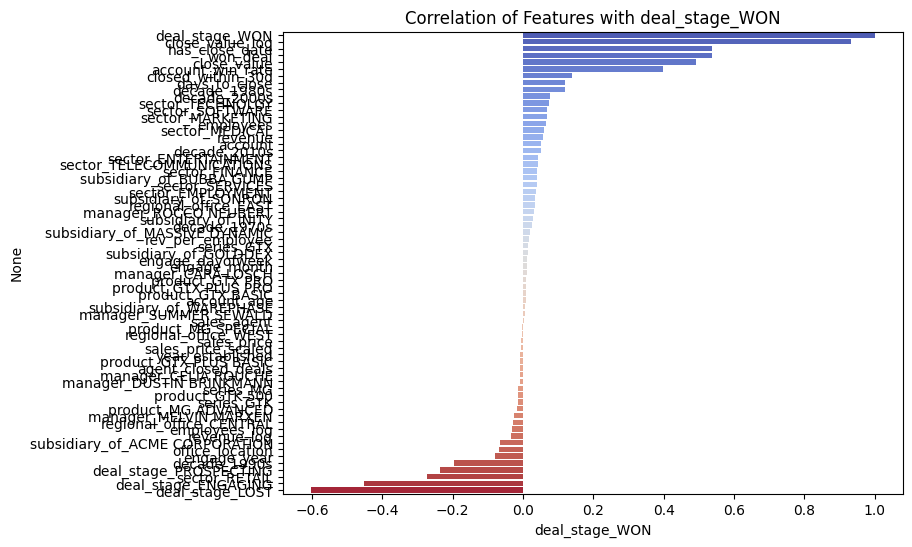

In [261]:
target = "deal_stage_WON"
corr = merged_df.corr(numeric_only=True)[target].sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=corr, y=corr.index, palette="coolwarm")
plt.title(f"Correlation of Features with {target}")
plt.show()

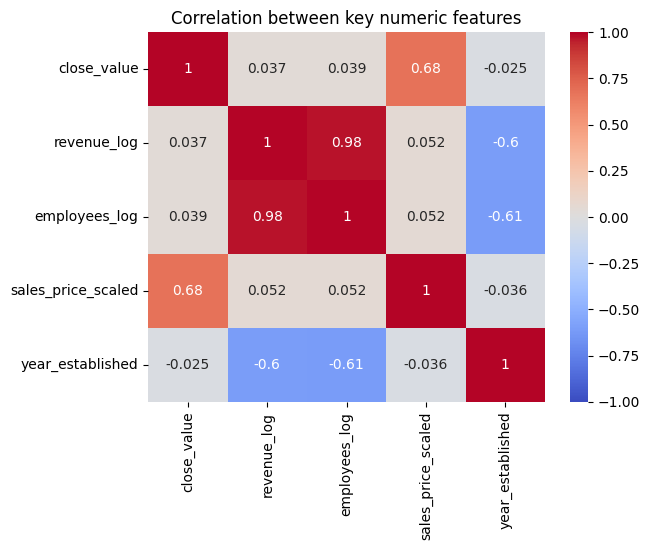

In [262]:
keep = ['close_value','revenue_log','employees_log','sales_price_scaled',
        'year_established']  # adjust as needed
sub = merged_df[ [c for c in keep if c in merged_df.columns] ].select_dtypes(include=[np.number])
sns.heatmap(sub.corr(), annot=True, vmin=-1, vmax=1, cmap='coolwarm')
plt.title('Correlation between key numeric features')
plt.show()

In [263]:
merged_df.head(10)

,sales_agent,account,engage_date,close_date,close_value,sales_price,year_established,revenue,employees,office_location,...,engage_year,engage_month,engage_dayofweek,days_to_close,closed_within_30d,account_age,rev_per_employee,agent_closed_deals,won_deal,account_win_rate
0,20,8,2016-10-20,2017-03-01,1054.0,1096,2001.0,718.62,2448.0,14,...,2016.0,10.0,3.0,132.0,0,24.0,0.293554,195,1,0.920792
1,6,38,2016-10-25,2017-03-11,4514.0,4821,2002.0,3178.24,4540.0,14,...,2016.0,10.0,1.0,137.0,0,23.0,0.700053,553,1,0.941176
2,6,8,2016-10-25,2017-03-07,50.0,55,2001.0,718.62,2448.0,14,...,2016.0,10.0,1.0,133.0,0,24.0,0.293554,553,1,0.920792
3,20,10,2016-10-25,2017-03-09,588.0,550,1998.0,2714.90,2641.0,14,...,2016.0,10.0,1.0,135.0,0,27.0,1.027982,195,1,0.966942
4,29,34,2016-10-25,2017-03-02,517.0,550,1982.0,792.46,1299.0,14,...,2016.0,10.0,1.0,128.0,0,43.0,0.610054,261,1,0.873563
5,0,58,2016-10-29,2017-03-01,49.0,55,1992.0,3922.42,6837.0,14,...,2016.0,10.0,5.0,123.0,0,33.0,0.573705,336,1,0.955357
6,26,40,2016-10-30,2017-03-02,57.0,55,1989.0,1388.67,3583.0,14,...,2016.0,10.0,6.0,123.0,0,36.0,0.387572,347,1,0.948052
7,17,9,2016-11-01,2017-03-07,601.0,550,1993.0,4269.90,6472.0,14,...,2016.0,11.0,1.0,126.0,0,32.0,0.659750,227,1,0.918367
8,21,84,2016-11-01,2017-03-03,1026.0,1096,1984.0,441.08,1210.0,14,...,2016.0,11.0,1.0,122.0,0,41.0,0.364529,175,1,0.904762
9,12,35,2016-11-03,NaT,NaN,3393,1995.0,1698.20,3492.0,14,...,2016.0,11.0,3.0,NaN,0,30.0,0.486312,206,0,0.118769


In [264]:
merged_df.columns

Index(['sales_agent', 'account', 'engage_date', 'close_date', 'close_value',
       'sales_price', 'year_established', 'revenue', 'employees',
       'office_location', 'has_close_date', 'close_value_log', 'revenue_log',
       'employees_log', 'product_GTK 500', 'product_GTX BASIC',
       'product_GTX PLUS BASIC', 'product_GTX PLUS PRO', 'product_GTX PRO',
       'product_MG ADVANCED', 'product_MG SPECIAL', 'manager_CARA LOSCH',
       'manager_CELIA ROUCHE', 'manager_DUSTIN BRINKMANN',
       'manager_MELVIN MARXEN', 'manager_ROCCO NEUBERT',
       'manager_SUMMER SEWALD', 'regional_office_CENTRAL',
       'regional_office_EAST', 'regional_office_WEST', 'series_GTK',
       'series_GTX', 'series_MG', 'sector_EMPLOYMENT', 'sector_ENTERTAINMENT',
       'sector_FINANCE', 'sector_MARKETING', 'sector_MEDICAL', 'sector_RETAIL',
       'sector_SERVICES', 'sector_SOFTWARE', 'sector_TECHNOLGY',
       'sector_TELECOMMUNICATIONS', 'subsidiary_of_ACME CORPORATION',
       'subsidiary_of_BUBBA

creating correlation matrix.

In [265]:
# Select only numeric features
numeric_features = merged_df.select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = numeric_features.corr().abs()

# Filter for strong correlations (> 0.9)
high_corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={0: 'correlation', 'level_0': 'feature_1', 'level_1': 'feature_2'})
    .query('correlation > 0.9')
    .sort_values(by='correlation', ascending=False)
)

print("Highly correlated feature pairs (> 0.9):")
display(high_corr_pairs)


Highly correlated feature pairs (> 0.9):


,feature_1,feature_2,correlation
744,product_GTK 500,series_GTK,1.000000
559,has_close_date,won_deal,1.000000
316,year_established,account_age,1.000000
242,sales_price,sales_price_scaled,1.000000
1528,series_GTX,series_MG,0.990064
616,revenue_log,employees_log,0.975571
321,revenue,employees,0.948414
600,close_value_log,deal_stage_WON,0.931975
599,close_value_log,deal_stage_LOST,0.931975
2243,days_to_close,closed_within_30d,0.912427


In [266]:
merged_df.to_csv(os.path.join(os.getcwd(), "data", "processed", "processed_data.csv"), index=False)

In [267]:
#creating the synthetic target column
import numpy as np
from sklearn.preprocessing import MinMaxScaler

df = merged_df.copy()
np.random.seed(42)

def robust_minmax(s):
    s = pd.to_numeric(s, errors='coerce')
    ql, qh = s.quantile(0.02), s.quantile(0.98)
    s = s.clip(ql, qh)
    mm = MinMaxScaler()
    return pd.Series(mm.fit_transform(s.values.reshape(-1,1)).ravel(), index=s.index)

# Revenue
rev = pd.to_numeric(df.get("revenue"), errors="coerce")
rev_01 = robust_minmax(rev.fillna(rev.median()))

# Revenue per employee
rpe = pd.to_numeric(df.get("rev_per_employee"), errors="coerce")
rpe_01 = robust_minmax(rpe.fillna(rpe.median()))

# Employees
emp = pd.to_numeric(df.get("employees"), errors="coerce")
emp_01 = robust_minmax(emp.fillna(emp.median()))

# Recency index for engagement activity
# calculation: 1 / (1 + days_since_last_close), where days_since_last_close = today - close_date; if close_date is missing, the max value (worst recency) is used
if "close_date" in df.columns:
    close_dt = pd.to_datetime(df["close_date"], errors="coerce")
    today = pd.Timestamp.today().normalize()
    days = (today - close_dt).dt.days
    # fill missing with max (worst recency)
    max_days = int(days.max()) if np.isfinite(days.max()) else 30
    days = days.fillna(max_days).clip(lower=0)

recency_index = 1.0 / (1.0 + days)
recency_01 = robust_minmax(recency_index)

# Deal margin:
# calculation: (close_value - sales_price) / sales_price
close_value = pd.to_numeric(df.get("close_value"), errors="coerce")
sales_price = pd.to_numeric(df.get("sales_price"), errors="coerce")
margin = (close_value - sales_price) / sales_price.replace(0, np.nan)
margin = margin.replace([np.inf, -np.inf], np.nan).fillna(0)
margin_01 = robust_minmax(margin)

# Winrate adj
# calculation: account_win_rate * log(1 + agent_closed_deals)
acc_win_rate = pd.to_numeric(df.get("account_win_rate"), errors="coerce").fillna(0)
agent_closed = pd.to_numeric(df.get("agent_closed_deals"), errors="coerce").fillna(0)
winrate_adj = acc_win_rate * np.log1p(agent_closed)
winrate_adj_01 = robust_minmax(winrate_adj)

# Product variety
# calculation: the sum of listed product columns (how many DISTINCT lines are purchased)
product_cols = [
    "product_GTK 500",
    "product_GTX BASIC",
    "product_GTX PLUS BASIC",
    "product_GTX PLUS PRO",
    "product_GTX PRO",
    "product_MG ADVANCED",
    "product_MG SPECIAL",
]
# handling any missing product_* columns
available_products = [c for c in product_cols if c in df.columns]
if available_products:
    # count DISTINCT lines that have been purchased (>0)
    prod_variety = (df[available_products].fillna(0) > 0).sum(axis=1)
else:
    prod_variety = pd.Series(0, index=df.index)
prod_variety_01 = robust_minmax(prod_variety)

# assigning weights, which sum to 1
w = {
    'revenue':          0.18,
    'rev_per_employee': 0.18,
    'employees':        0.08,
    'recency':          0.18,
    'margin':           0.13,
    'winrate_adj':      0.15,
    'product_variety':  0.10
}

# final account health score computation
# adding some noise so the model has something to learn
noise = np.random.normal(0, 0.02, size=len(df))
score_raw = (
    w['revenue']          * rev_01.values +
    w['rev_per_employee'] * rpe_01.values +
    w['employees']        * emp_01.values +
    w['recency']          * recency_01.values +
    w['margin']           * margin_01.values +
    w['winrate_adj']      * winrate_adj_01.values +
    w['product_variety']  * prod_variety_01.values +
    noise
)

# scaling to 0–100
score_01 = robust_minmax(pd.Series(score_raw, index=df.index))
df['account_health_score'] = (score_01 * 100).round(2)
df['account_health_score'] = pd.to_numeric(df['account_health_score'], errors='coerce') \
                                .replace([np.inf, -np.inf], np.nan) \
                                .fillna(df['account_health_score'].median())

# keep working dataframe named df for the next steps
print("Synthetic target created. Summary:")
display(df[['account_health_score']].describe())


Synthetic target created. Summary:


,account_health_score
count,8800.000000
mean,41.187847
std,26.922925
min,0.000000
25%,16.675000
50%,39.905000
75%,61.115000
max,100.000000


In [268]:
#deciding on features for the model

target_col = 'account_health_score'
#numeric features
X_full = df.select_dtypes(include=[np.number]).copy()
#dropping IDs, dates (unique identifiers)
drop_like = ['id','uuid','account_id','customer_id','date','created','updated','timestamp']
to_drop = set([c for c in X_full.columns for k in drop_like if k in c.lower()])
to_drop.add(target_col)

feature_pool = [c for c in X_full.columns if c not in to_drop]
X_pool = X_full[feature_pool].replace([np.inf,-np.inf], np.nan)
X_pool = X_pool.fillna(X_pool.median(numeric_only=True))
#checking for columns with >0.95 correlation and dropping them
corr = X_pool.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
high_corr_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_dedup = X_pool.drop(columns=high_corr_drop, errors='ignore')

from IPython.display import display
display(pd.Series(high_corr_drop, name="Dropped for high correlation (>0.95)"))

y = pd.to_numeric(df[target_col], errors='coerce')
mask = y.notna() & np.isfinite(y)
X = X_dedup.loc[mask].copy()
y = y.loc[mask].copy()
#using the top top_k features with the highest correlation to target to train the model
#we do this because features with the highest correlation to target are the variables that vary most strongly with the target;
#they are the features with the greatest influence on the target
corr_to_y = X.apply(lambda s: s.corr(y)).abs().sort_values(ascending=False)
top_k = min(50, len(corr_to_y))  #can change top_k if we want to
selected_features = list(corr_to_y.head(top_k).index)
display(pd.Series(selected_features, name="Selected features"))

X = X[selected_features].copy()

,Dropped for high correlation (>0.95)
0,employees_log
1,series_GTK
2,series_MG
3,sales_price_scaled
4,account_age


,Selected features
0,revenue
1,deal_stage_WON
2,account_win_rate
3,employees
4,won_deal
5,deal_stage_ENGAGING
6,revenue_log
7,sector_RETAIL
8,sector_SOFTWARE
9,close_value


In [269]:
#creating model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV

# 80 / 20 train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler_X = StandardScaler()
X_train_sc = scaler_X.fit_transform(X_train)
X_test_sc  = scaler_X.transform(X_test)

#ElasticNetCV is a linear model w/ built in CV
# shrinks & balances heavy amts of correlated features
# this type of model includes regularization (penalizes large/unnecessary coefficients), reducing overfitting
# 5 fold cross validation
# automatically learns alpha values, which indicates regularization strength
# l1 ratio values -> 0 would mean pure L2 and 1 would mean pure L1 regularization
enet = ElasticNetCV(l1_ratio=[0.2, 0.5, 0.8], alphas=None, cv=5, random_state=42)
enet.fit(X_train_sc, y_train)
# stores & prints best combination
print("l1_ratio:", enet.l1_ratio_, "| alpha:", enet.alpha_)


l1_ratio: 0.8 | alpha: 0.019989512083096475


In [270]:
# STEP 4: evaluate (R², MAE, RMSE)
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

pred_enet = enet.predict(X_test_sc)
r2  = r2_score(y_test, pred_enet)
mae = mean_absolute_error(y_test, pred_enet)
rmse = np.sqrt(mean_squared_error(y_test, pred_enet))

print(f"R²: {r2:0.4f} | MAE: {mae:0.2f} | RMSE: {rmse:0.2f}")
print("Target met (R² ≥ 0.70):", r2 >= 0.70)


R²: 0.9466 | MAE: 4.89 | RMSE: 6.33
Target met (R² ≥ 0.70): True


In [271]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
gbr.fit(X_train, y_train)

pred_gbr = gbr.predict(X_test)
r2_gbr  = r2_score(y_test, pred_gbr)
mae_gbr = mean_absolute_error(y_test, pred_gbr)
rmse_gbr = np.sqrt(mean_squared_error(y_test, pred_gbr))

print(f"[GBR]       R²: {r2_gbr:0.4f} | MAE: {mae_gbr:0.2f} | RMSE: {rmse_gbr:0.2f}")
print("Target met (R² ≥ 0.70):", r2_gbr >= 0.70)


[GBR]       R²: 0.9665 | MAE: 4.00 | RMSE: 5.02
Target met (R² ≥ 0.70): True


In [272]:
#time-based split using close_date
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet

#using the same optimal hyperparameters from ElasticNetCV
alpha = enet.alpha_
l1r = enet.l1_ratio_

#converting close_date to date objects
if "close_date" in df.columns:
    df_dates = pd.to_datetime(df["close_date"], errors="coerce")
    # align with X,y indices
    common_idx = X.index.intersection(y.index).intersection(df_dates.index)
    df_dates = df_dates.loc[common_idx]
    X_time = X.loc[common_idx]
    y_time = y.loc[common_idx]

    # split = 80% oldest goes to train and the 20% newest goes to test)
    cutoff = df_dates.quantile(0.80)
    train_idx = df_dates[df_dates <= cutoff].index
    test_idx  = df_dates[df_dates >  cutoff].index

    scaler = StandardScaler()
    Xtr = scaler.fit_transform(X_time.loc[train_idx])
    Xte = scaler.transform(X_time.loc[test_idx])

    enet_time = ElasticNet(alpha=alpha, l1_ratio=l1r, random_state=42, max_iter=10000)
    enet_time.fit(Xtr, y_time.loc[train_idx])

    preds = enet_time.predict(Xte)
    r2_time = r2_score(y_time.loc[test_idx], preds)

    print("Time-based split R²:", round(r2_time, 4))


Time-based split R²: 0.9324


In [273]:
# include some columns from the original dataset
results_time = pd.DataFrame({
    "account": df.loc[test_idx, "account"],
    "close_date": df_dates.loc[test_idx],
    "engage_date": df.loc[test_idx,"engage_date"],
    "revenue":df.loc[test_idx, "revenue"],
    "employees":df.loc[test_idx, "employees"],
    "rev_per_employee":df.loc[test_idx,"rev_per_employee"],
    "actual_health_score": y_time.loc[test_idx],
    "predicted_health_score": preds
})

# absolute error between synthetic target score and predicted score
results_time["abs_error"] = (
    results_time["actual_health_score"] - results_time["predicted_health_score"]
).abs().round(2)

#round values & sorting
results_time = results_time.sort_values("close_date")
results_time["actual_health_score"] = results_time["actual_health_score"].round(2)
results_time["predicted_health_score"] = results_time["predicted_health_score"].round(2)

# display sample results
print("\nSample of the most recent 10 by close_date:")
display(results_time.tail(10))


Sample of the most recent 10 by close_date:


,account,close_date,engage_date,revenue,employees,rev_per_employee,actual_health_score,predicted_health_score,abs_error
8014,38,2017-12-31,2017-11-12,3178.24,4540.0,0.700053,94.52,93.28,1.24
7304,33,2017-12-31,2017-10-06,223.80,299.0,0.748495,68.03,68.12,0.09
7306,10,2017-12-31,2017-10-06,2714.90,2641.0,1.027982,100.00,105.70,5.70
7523,58,2017-12-31,2017-10-14,3922.42,6837.0,0.573705,73.49,69.96,3.53
7945,29,2017-12-31,2017-11-05,86.68,187.0,0.463529,51.57,55.87,4.30
7636,16,2017-12-31,2017-10-18,587.72,1501.0,0.391552,32.62,36.68,4.06
7925,54,2017-12-31,2017-11-03,349.81,315.0,1.110508,85.43,85.40,0.03
8266,9,2017-12-31,2017-12-17,4269.90,6472.0,0.659750,100.00,98.38,1.62
7779,23,2017-12-31,2017-10-24,2059.90,3644.0,0.565285,73.59,75.43,1.84
7281,26,2017-12-31,2017-10-05,2520.83,3502.0,0.719826,96.85,90.16,6.69


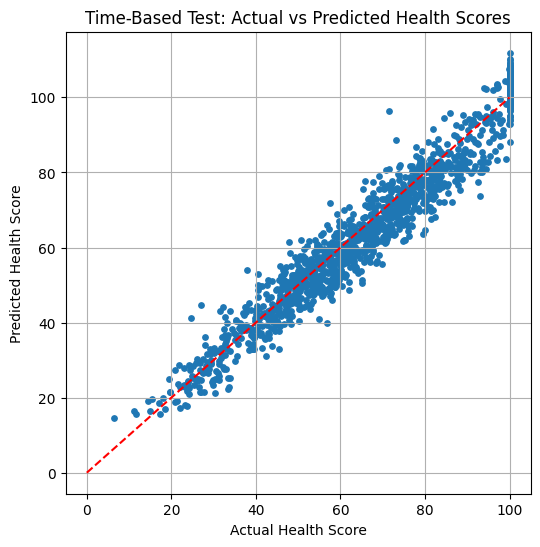

In [274]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(results_time["actual_health_score"], results_time["predicted_health_score"], s=15)
plt.plot([0, 100], [0, 100], "r--")  # perfect-fit diagonal
plt.xlabel("Actual Health Score")
plt.ylabel("Predicted Health Score")
plt.title("Time-Based Test: Actual vs Predicted Health Scores")
plt.grid(True)
plt.show()
